# Validation and Benchmarking of European Renewable Generation Dataset

## Table of Contents

* [1 Introduction](#1-introduction)
  * [1.1 Motivation and Context](#11-motivation-and-context)
  * [1.2 Contributions](#12-contributions)
* [2 Input Data](#2-input-data)
  * [2.1 Load Generated Datasets (2015-2025)](#21-load-generated-datasets-2015-2025)
  * [2.2 Load Reported Generation (Validation Data)](#22-load-reported-generation-validation-data)
* [3 Sensitivity Analyses](#3-sensitivity-analyses)
  * [3.1 Sensitivity of Wind Generation to Turbine Model Choice](#31-sensitivity-of-wind-generation-to-turbine-model-choice)
  * [3.2 Sensitivity to Farm-Aggregation Smoothing](#32-sensitivity-to-farm-aggregation-smoothing)
  * [3.3 Sensitivity of PV Generation to Configuration Assumptions](#33-sensitivity-of-pv-generation-to-configuration-assumptions)
  * [3.4 Sensitivity to Calibration Settings](#34-sensitivity-to-calibration-settings)
* [4 Validation Results (2015-2025)](#4-validation-results-2015-2025)
  * [4.1 Evaluation Metrics](#41-evaluation-metrics)
  * [4.2 Wind Generation Validation](#42-wind-generation-validation)
  * [4.3 Solar Generation Validation](#43-solar-generation-validation)
  * [4.4 Hydropower Consistency Checks](#44-hydropower-consistency-checks)
  * [4.5 Cross-technology and Spatial Correlation](#45-cross-technology-and-spatial-correlation)
* [5 Weather-driven Variability Results (2005-2025)](#5-weather-driven-variability-results-2005-2025)
* [6 Conclusion](#6-conclusion)

## 1. Introduction
### Motivation and Context
High-resolution hourly renewable generation time series are required for energy system modeling, including adequacy assessment, storage and flexibility sizing, transmission expansion, and evaluation of weather-driven risk.

This notebook implements the validation and benchmarking of the dataset defined in the accompanying article. It covers:
1. **Sensitivity Analyses**: Quantifying the robustness of the dataset to key modeling assumptions and heuristics.
2. **Validation Results**: Comparing the calibrated historical generation dataset (2015–2025) against reported generation (ENTSO-E Transparency Platform).
3. **Weather-driven Variability**: Analyzing the fixed-layout dataset (2005–2025) to isolate weather effects from capacity expansion.

### Contributions
- Validate country-level aggregated wind and solar PV generation.
- Validate bidding-zone level generation for Norway, Sweden, and Denmark.
- Assess sensitivity to turbine model choice, spatial smoothing, and PV configuration assumptions.

In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import importlib
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Add parent directory to path to import functions
sys.path.append(os.path.abspath('..'))
import functions

sns.set_style("darkgrid")
%matplotlib inline

# Configure plot fonts
plt.rcParams.update({'font.size': 12})

## 2. Input Data
### 2.1 Load Generated Datasets (2015-2025)
We load the aggregated wind and solar power generation datasets. These files are produced by the generation scripts (`solar_production_aggregated_generation.py`, etc.).

In [40]:
MONTH = "02"
YEAR = "2024"

In [41]:
#Paths to generated NetCDF files
nc_path = Path(f"/Data/gfi/vindenergi/nab015/highres-renewable-dataset/country-aggregated-production/{YEAR}/{MONTH}_{YEAR}_pv_wind_country_timeseries.nc")  
nc_path_perfarm = Path(f"/Data/gfi/vindenergi/nab015/highres-renewable-dataset/per-farm-production/{YEAR}/{MONTH}_{YEAR}_pv_wind_grid.nc")

if nc_path.exists():
    ds = xr.open_dataset(nc_path, engine='h5netcdf')
    print("Dataset loaded.")
else:
    print(f"File not found at {nc_path}")

if nc_path_perfarm.exists():
    ds_perfarm = xr.open_dataset(nc_path_perfarm, engine='h5netcdf')
    print("Per-farm dataset loaded.")
else:
    print(f"File not found at {nc_path_perfarm}")

Dataset loaded.
Per-farm dataset loaded.


In [42]:
ds

<xarray.Dataset> Size: 989kB
Dimensions:             (time: 696, area: 44)
Coordinates:
  * time                (time) datetime64[ns] 6kB 2024-02-01T01:00:00 ... 202...
  * area                (area) <U21 4kB 'Austria (AT)' ... 'Kosovo (XK)'
Data variables:
    pv_power_mw         (time, area) float64 245kB ...
    pv_power_mw_2025    (time, area) float64 245kB ...
    wind_power_mw       (time, area) float64 245kB ...
    wind_power_mw_2025  (time, area) float64 245kB ...
Attributes:
    year:          2024
    month_number:  02
    month_name:    feb
    note:          as-built calibrated factor applied to both as-built and 20...

In [43]:
ds_perfarm

<xarray.Dataset> Size: 6GB
Dimensions:        (time: 696, y: 1069, x: 1069)
Coordinates:
  * time           (time) datetime64[ns] 6kB 2024-02-01T01:00:00 ... 2024-03-01
  * y              (y) int64 9kB 0 1 2 3 4 5 6 ... 1063 1064 1065 1066 1067 1068
  * x              (x) int64 9kB 0 1 2 3 4 5 6 ... 1063 1064 1065 1066 1067 1068
    latitude       (y, x) float64 9MB ...
    longitude      (y, x) float64 9MB ...
Data variables:
    wind_power_mw  (time, y, x) float32 3GB ...
    pv_power_mw    (time, y, x) float32 3GB ...

### 2.2 Load Reported Generation (Validation Data)
We load the actual generation data from ENTSO-E or national TSOs for validation.

In [44]:
actual_gen_path = Path(f"/Data/gfi/vindenergi/nab015/Actual_Generation/AggregatedGenerationPerType/{YEAR}/{YEAR}_{MONTH}_AggregatedGenerationPerType_16.1.B_C_r3.csv")

if actual_gen_path.exists():
    df_actual = pd.read_csv(actual_gen_path, sep='\t')
    # Preprocessing to align timestamps and TimeZones
    # (Implementation details depend on the specific format columns)
    print("Actual generation data loaded.")
else:
    print(f"Actual generation file not found at {actual_gen_path}")

Actual generation data loaded.


### 2.3 Map of European renewable production
Plotting the high-resolution grid (5.5kmx5.5km) with total wind + PV power generation 

In [45]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors

total_wind_production = ds_perfarm['wind_power_mw'].sum(dim='time')
total_pv_production = ds_perfarm['pv_power_mw'].sum(dim='time')
wind_2d = total_wind_production.squeeze()
pv_2d = total_pv_production.squeeze()
if wind_2d.dims != ('y', 'x'):
    wind_2d = wind_2d.transpose('y', 'x')
if pv_2d.dims != ('y', 'x'):
    pv_2d = pv_2d.transpose('y', 'x')
total_production = wind_2d + pv_2d

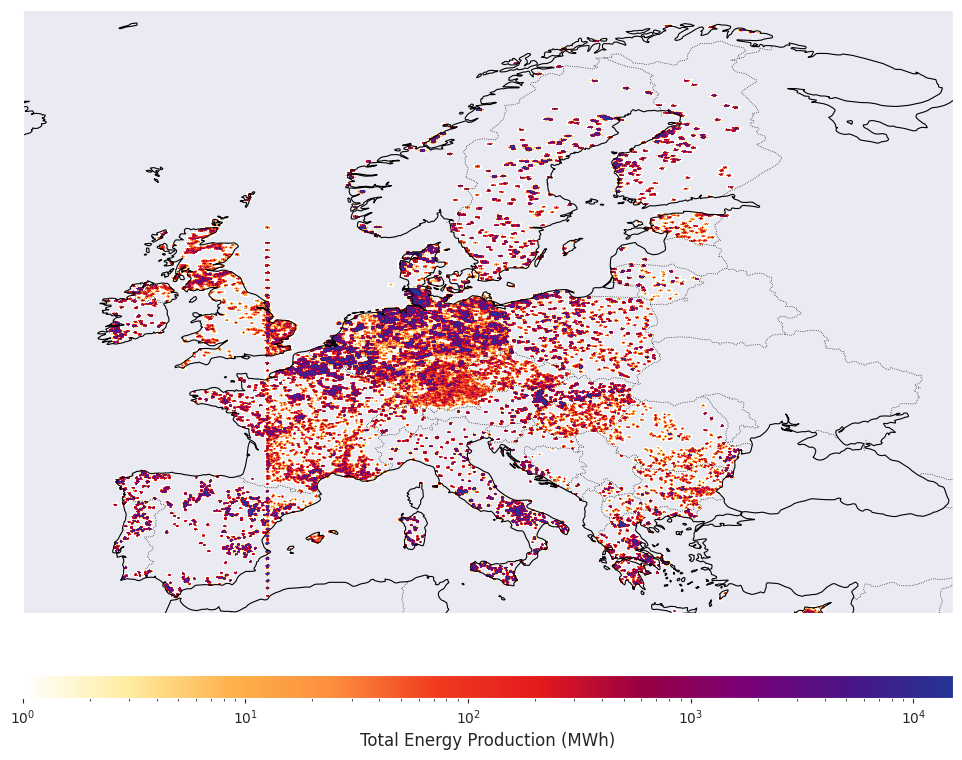

In [46]:
# 2. Gaussian Smoothing
sigma = 0.5
power_values_smoothed = gaussian_filter(total_production.values, sigma=sigma)
power_2d_smoothed = total_production.copy(data=power_values_smoothed)

# 3. Create Custom Colormap
colors = ["white", "#ffeda0", "#feb24c", "#fd8d3c", "#f03b20", "#e31a1c", "#980043", "#7a0177", "#4a1486", "#253494"]
cmap_custom = mcolors.LinearSegmentedColormap.from_list("white_red_blue", colors, N=256)

# 4. Plotting with Cartopy
plt.figure(figsize=(12, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-15, 42, 35, 72], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, zorder=2)

# 5. Plot data with Logarithmic Scale
# vmin is set to 1 because LogNorm requires values > 0
pcm = power_2d_smoothed.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    x='longitude', 
    y='latitude',
    cmap=cmap_custom,
    add_colorbar=False,
    rasterized=True,
    norm=mcolors.LogNorm(vmin=1, vmax=1.5e4)
)

# 6. Custom Colorbar
cbar = plt.colorbar(pcm, orientation='horizontal', pad=0.05, fraction=0.04, aspect=40)
cbar.set_label('Total Energy Production (MWh)', fontsize=12)
cbar.ax.tick_params(labelsize=10)
plt.show()
# plt.title(f'Total monthly wind + solar production in Europe ({month_number}-{YEAR})')
# plt.savefig(f'/Data/gfi/vindenergi/nab015/figures/total_energy_production_log_{month_number}_{YEAR}.svg', dpi=400, bbox_inches='tight', pad_inches=0)

## 3. Sensitivity Analyses
This section quantifies the robustness of the dataset to key modeling and heuristic assumptions.

### 3.1 Sensitivity of Wind Generation to Turbine Model Choice
We evaluate how wind generation changes under alternative turbine model mappings:
1. **Baseline**: Year/type-based mapping (`map_turbine_model`).
2. **Low Cut-in**: Using models with lower cut-in speeds.
3. **High Cut-in**: Using models with higher cut-in speeds.
4. **Fixed Reference**: Using a single reference turbine per class.

In [47]:
def test_wind_sensitivity(lat, lon, start_year, installation_type, xrds, scenario='baseline'):
    """
    Wrapper to estimate wind power with different turbine model assumptions.
    This mocks the behavior of changing the map_turbine_model function.
    """
    # Mock turbine mapping based on scenario
    if scenario == 'baseline':
        model = functions.map_turbine_model(start_year, installation_type)
    elif scenario == 'low_cut_in':
        model = "VestasV47_660kW_47" # Example of older/lower-wind model
    elif scenario == 'high_cut_in':
        model = "IEA_Reference_15MW_240" # Example of large offshore (typically higher rated wind speed)
    
    # Here we would call a modified version of estimate_wind_power that accepts 'model_override'
    # For this outline, we assume estimate_wind_power is used as is, or we'd duplicate logic here.
    pass

# Placeholder loop for running sensitivity
scenarios = ['baseline', 'low_cut_in', 'high_cut_in']
results_wind = {}
# for scen in scenarios:
#    results_wind[scen] = ...

### 3.2 Sensitivity to Farm-Aggregation Smoothing
We test the impact of the Gaussian smoothing width $\sigma(w)$ on ramp rates and spikiness.

In [ ]:
# Code to vary the 'wts_smoothing' or the internal Gaussian spread in generate_farm_power_curve
# Compare ramp rate distributions (diff(t) - diff(t-1))

### 3.3 Sensitivity of PV Generation to Configuration Assumptions
- Fixed-tilt rule ($|\phi|-5$) vs alternatives.
- Tracking heuristic thresholds.
- Twilight zenith limit.

In [ ]:
# Example: Compare Fixed vs Tracking for a specific farm
lat, lon = 40.4168, -3.7038 # Spain example
# call functions.estimate_power_final with mounting_type='fixed'
# call functions.estimate_power_final with mounting_type='single_axis'
# Plot the diurnal profiles in Summer vs Winter

### 3.4 Sensitivity to Calibration Settings
Testing robustness of correction factors (stable-band width, minimum power threshold).

## 4. Validation Results (2015-2025)
### 4.1 Evaluation Metrics
Calculate MAE, RMSE, Bias, and $R^2$ for each country and bidding zone.

In [48]:
def calculate_metrics(simulated_ts, actual_ts):
    common_idx = simulated_ts.index.intersection(actual_ts.index)
    if len(common_idx) == 0:
        return None
    
    sim = simulated_ts.loc[common_idx]
    act = actual_ts.loc[common_idx]
    
    bias = (sim - act).mean()
    mae = mean_absolute_error(act, sim)
    rmse = np.sqrt(mean_squared_error(act, sim))
    corr, _ = pearsonr(act, sim)
    
    return {'Bias': bias, 'MAE': mae, 'RMSE': rmse, 'R2': corr**2}

### 4.2 Wind generation validation

In [49]:
country_list = ds['area']
country_names = country_list.values.tolist()
metrics_df = pd.DataFrame(index=country_names, columns=['Bias', 'MAE', 'RMSE', 'R2'])

for country in country_names:
    simulated = ds['wind_power_mw'].sel(area=country).to_pandas()
    actual = df_actual.loc[
        (df_actual['AreaDisplayName'] == country) &
        (df_actual['ProductionType'].str.contains('Wind', case=False, na=False))
    ].copy()

    actual = actual.groupby('DateTime(UTC)')['ActualGenerationOutput[MW]'].sum()
    actual.index = pd.to_datetime(actual.index)
    simulated.index = pd.to_datetime(simulated.index)
    metrics = calculate_metrics(simulated, actual)
    if metrics is not None:
        metrics_df.loc[country] = metrics

metrics_df

/tmp/ipykernel_3937813/149717958.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(act, sim)
/tmp/ipykernel_3937813/149717958.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(act, sim)
/tmp/ipykernel_3937813/149717958.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(act, sim)
/tmp/ipykernel_3937813/149717958.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(act, sim)
/tmp/ipykernel_3937813/149717958.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(act, sim)


,Bias,MAE,RMSE,R2
Austria (AT),32.707471,324.50692,411.216976,0.814022
Bosnia and Herz. (BA),4.384266,10.592373,15.127389,0.716005
Belgium (BE),202.254512,385.92232,505.253855,0.887183
Bulgaria (BG),11.354137,42.666975,56.349268,0.891316
Switzerland (CH),-1.033684,7.115596,9.268867,0.716349
Cyprus (CY),NaN,NaN,NaN,NaN
Czech Republic (CZ),-3.803912,21.068992,26.501709,0.893181
Germany (DE),259.611217,2433.007694,3012.899192,0.955567
DK1,-2.043458,432.696189,545.501739,0.862716
DK2,61.076285,161.285834,228.673726,0.791412


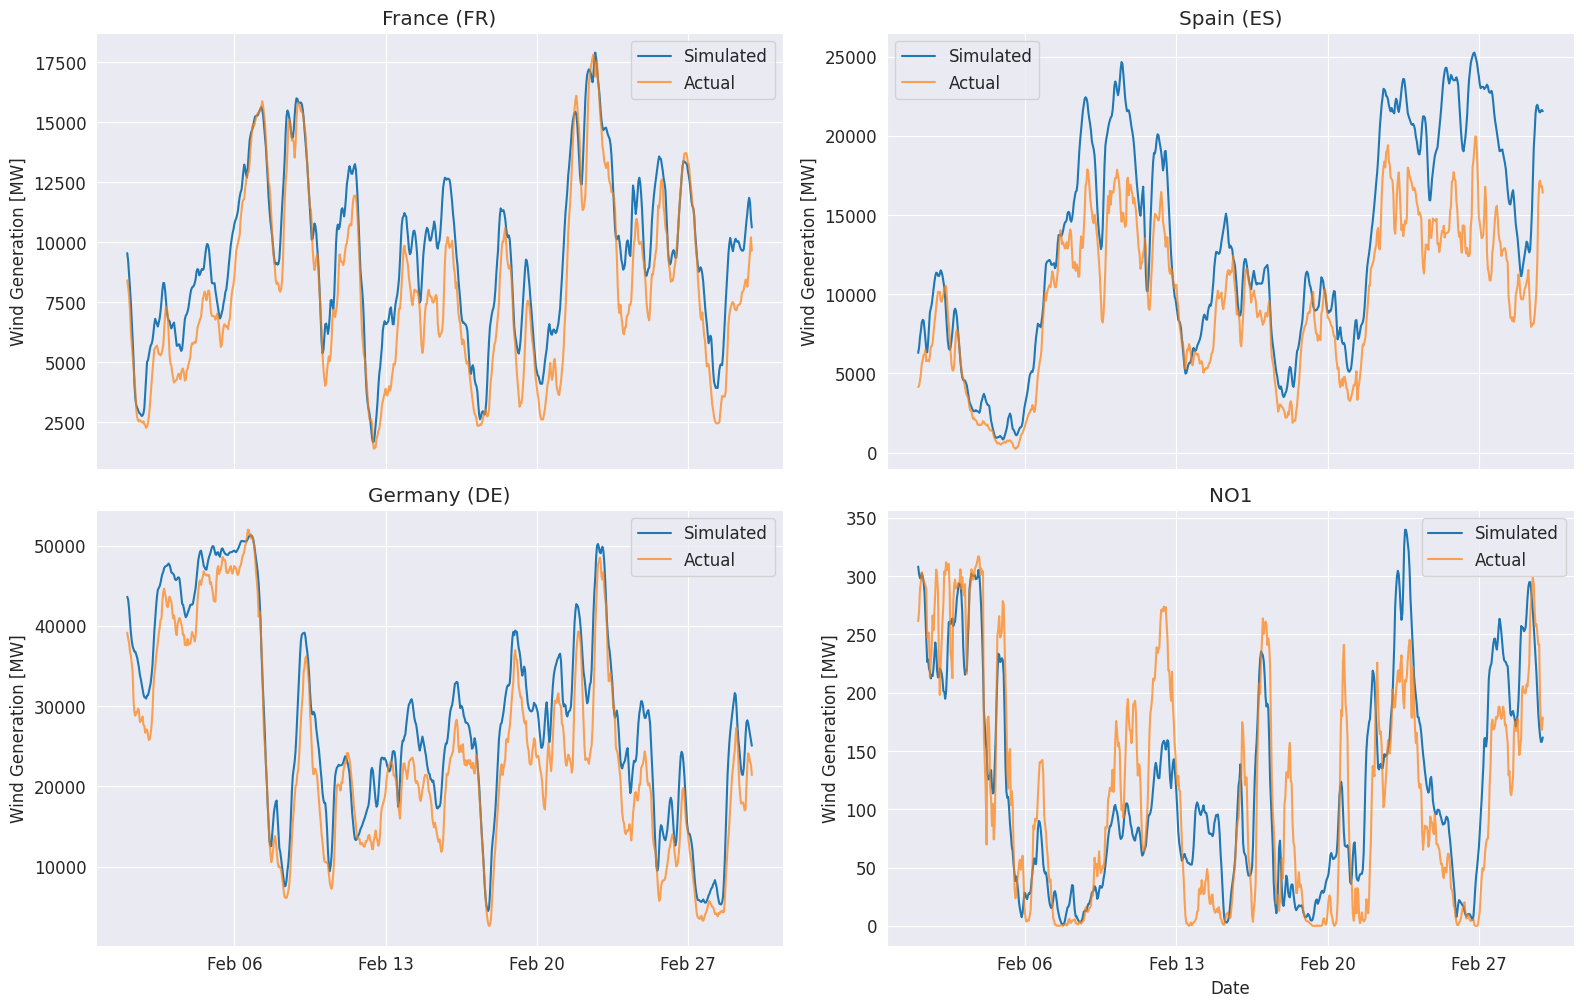

In [50]:
countries_to_plot = ['France (FR)', 'Spain (ES)', 'Germany (DE)', 'NO1']
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()

for i, country in enumerate(countries_to_plot):
    #Simulated wind
    sim = ds['wind_power_mw_2025'].sel(area=country).to_pandas()
    #Actual wind
    act = df_actual.loc[
        (df_actual['AreaDisplayName'] == country) &
        (df_actual['ProductionType'].str.contains('Wind', case=False, na=False))
    ].copy()
    act = act.groupby('DateTime(UTC)')['ActualGenerationOutput[MW]'].sum()
    act.index = pd.to_datetime(act.index)
    sim.index = pd.to_datetime(sim.index)
    #Align indices
    common_idx = sim.index.intersection(act.index)
    sim = sim.loc[common_idx]
    act = act.loc[common_idx]

    axes[i].plot(sim, label='Simulated', color='tab:blue')
    axes[i].plot(act, label='Actual', color='tab:orange', alpha=0.7)
    axes[i].set_title(country)
    axes[i].set_ylabel('Wind Generation [MW]')
    axes[i].legend()
    axes[i].xaxis.set_major_locator(mdates.WeekdayLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.xlabel('Date')
plt.show()

/tmp/ipykernel_3937813/1087594336.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=normalized_rmse_series_sorted.index, y=normalized_rmse_series_sorted.values, palette="viridis")


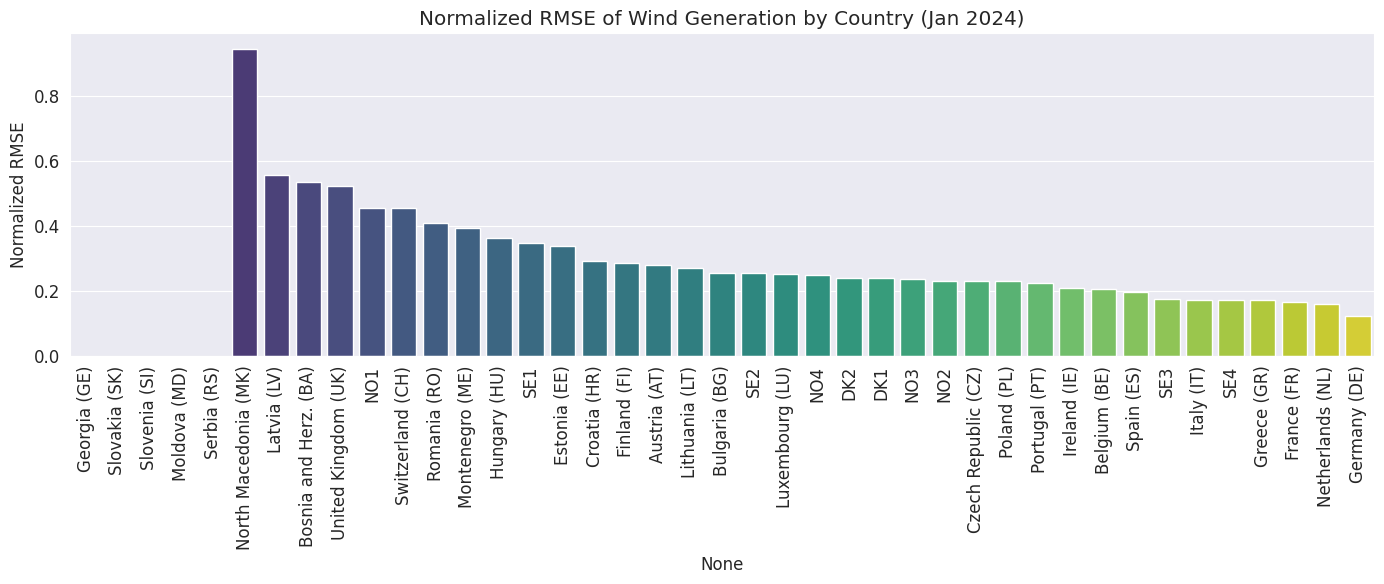

In [55]:
plt.figure(figsize=(14, 6))
rmse_series = metrics_df['RMSE'].astype(float)
rmse_series_sorted = rmse_series.sort_values(ascending=False)
mean_production = ds['wind_power_mw'].mean(dim='time').to_pandas()
normalized_rmse = (rmse_series / mean_production).dropna()
normalized_rmse_series_sorted = normalized_rmse.sort_values(ascending=False)
sns.barplot(x=normalized_rmse_series_sorted.index, y=normalized_rmse_series_sorted.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Normalized RMSE")
plt.title("Normalized RMSE of Wind Generation by Country (Jan 2024)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3937813/545079144.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rmse_series_sorted.index, y=rmse_series_sorted.values, palette="viridis")


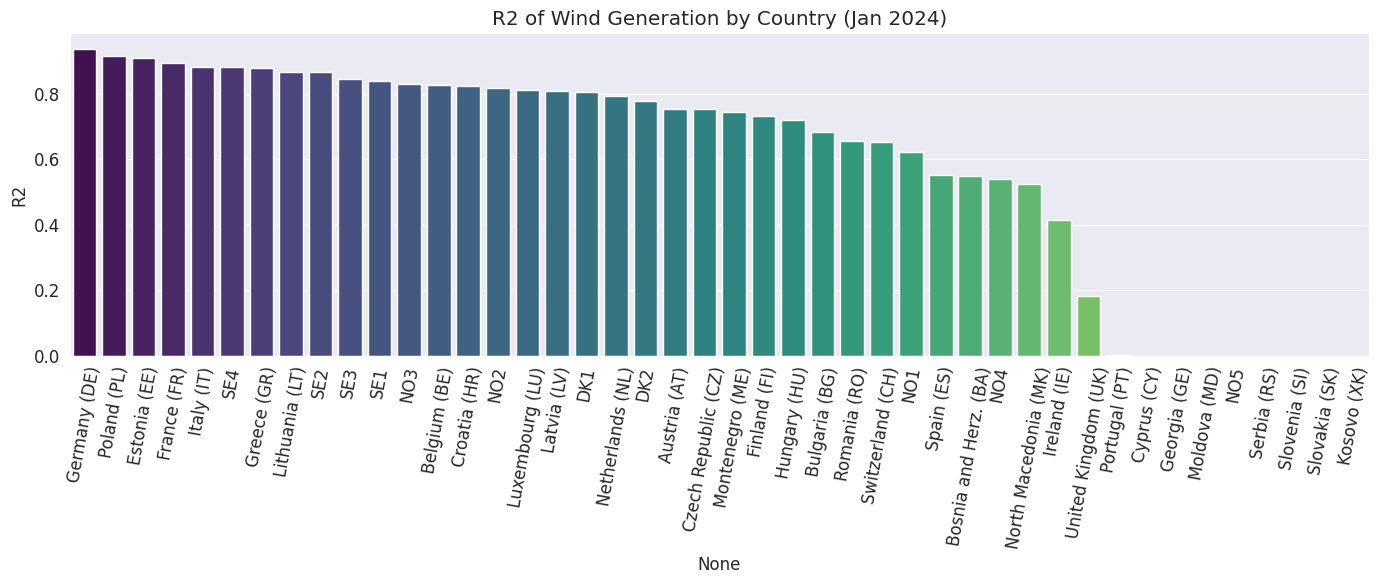

In [23]:
plt.figure(figsize=(14, 6))
rmse_series = metrics_df['R2'].astype(float)
rmse_series_sorted = rmse_series.sort_values(ascending=False)
sns.barplot(x=rmse_series_sorted.index, y=rmse_series_sorted.values, palette="viridis")
plt.xticks(rotation=80)
plt.ylabel("R2")
plt.title("R2 of Wind Generation by Country (Jan 2024)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3937813/920318972.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rmse_series_sorted.index, y=rmse_series_sorted.values, palette="viridis")


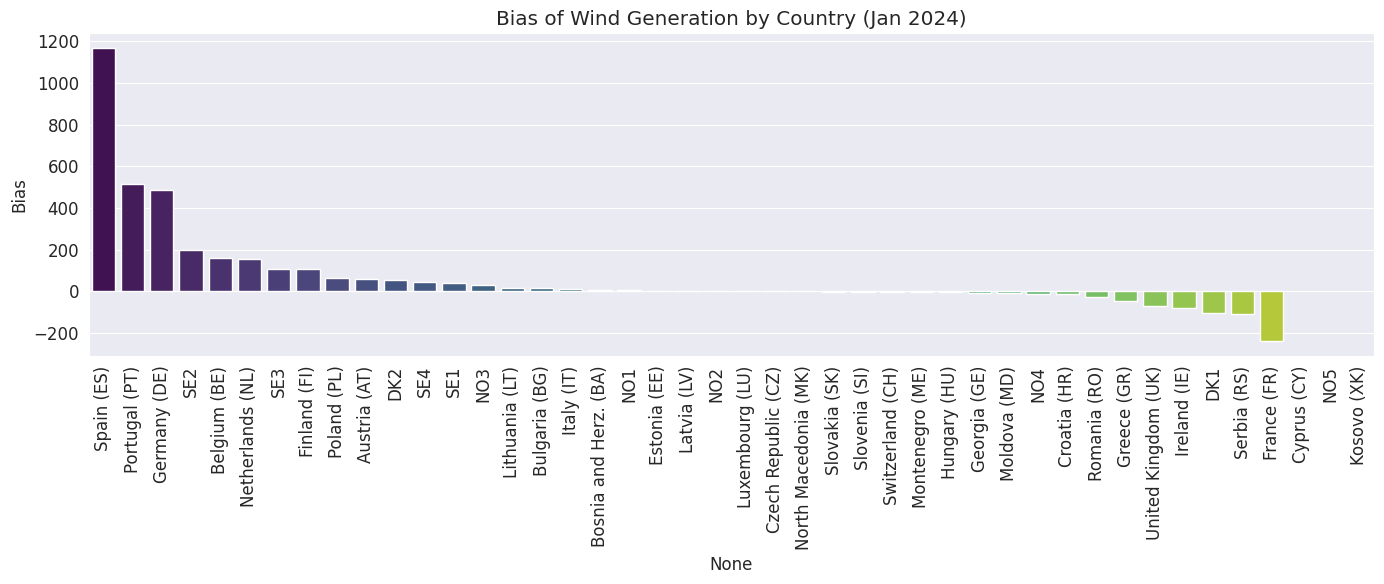

In [24]:
plt.figure(figsize=(14, 6))
rmse_series = metrics_df['Bias'].astype(float)
rmse_series_sorted = rmse_series.sort_values(ascending=False)
sns.barplot(x=rmse_series_sorted.index, y=rmse_series_sorted.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Bias")
plt.title("Bias of Wind Generation by Country (Jan 2024)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3937813/4161606747.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=normalized_mae.index, y=normalized_mae.values, palette="viridis")


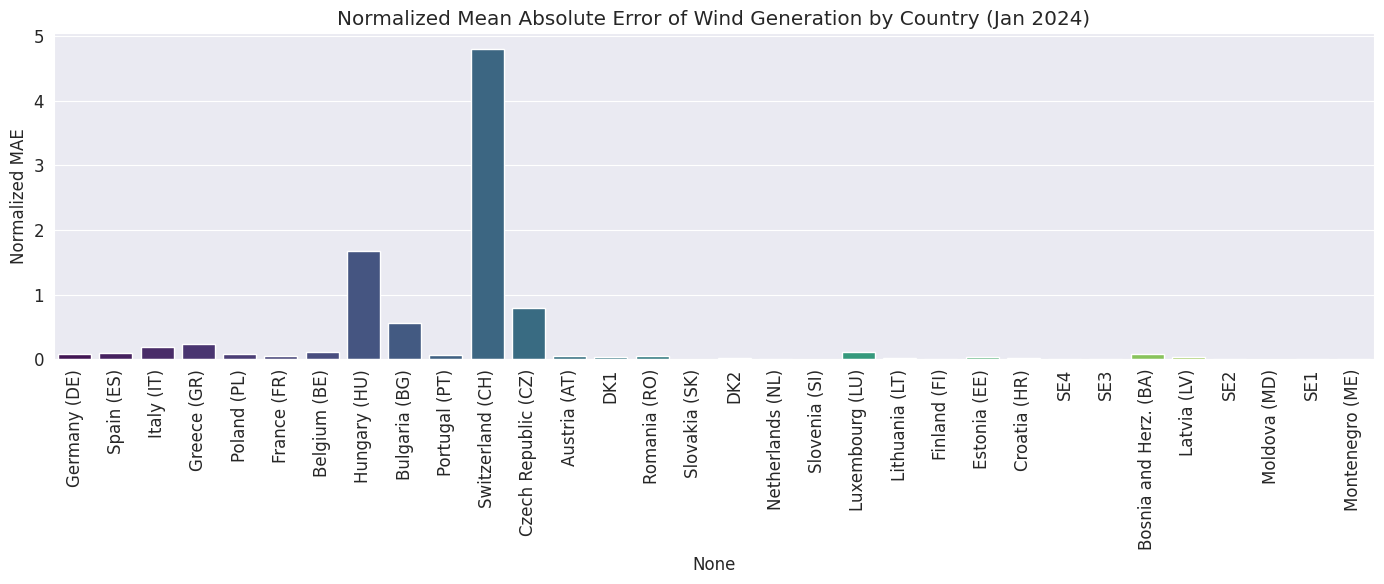

In [34]:
plt.figure(figsize=(14, 6))
rmse_series = metrics_df['MAE'].astype(float)
rmse_series_sorted = rmse_series.sort_values(ascending=False).dropna()
mean_production = ds['wind_power_mw'].mean(dim='time').to_pandas()
mean_production = mean_production.loc[rmse_series_sorted.index]
normalized_mae = rmse_series_sorted / mean_production
sns.barplot(x=normalized_mae.index, y=normalized_mae.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Normalized MAE")
plt.title("Normalized Mean Absolute Error of Wind Generation by Country (Jan 2024)")
plt.tight_layout()
plt.show()

### 4.3 Solar Generation Validation
Focus on high-latitude performance and tracking/fixed heuristics.

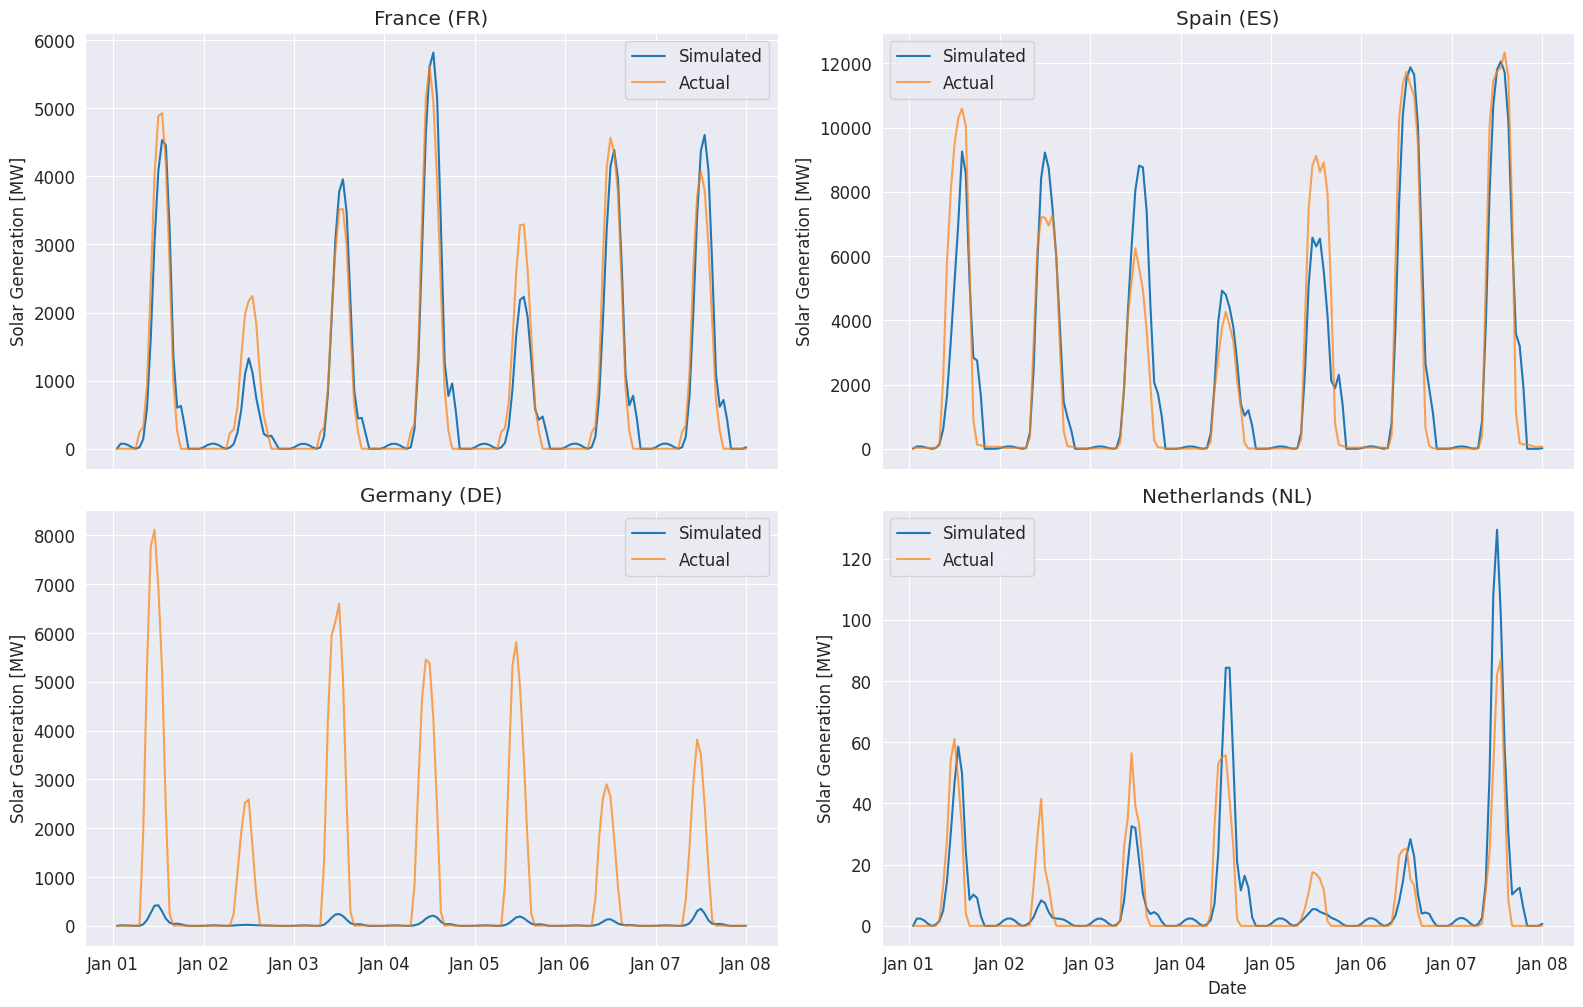

In [29]:
countries_to_plot = ['France (FR)', 'Spain (ES)', 'Germany (DE)', 'Netherlands (NL)']
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()

for i, country in enumerate(countries_to_plot):
    # Simulated solar
    sim = ds['pv_power_mw'].sel(area=country).to_pandas()
    # Actual solar
    act = df_actual.loc[
        (df_actual['AreaDisplayName'] == country) &
        (df_actual['ProductionType'].str.contains('Solar', case=False, na=False))
    ].copy()
    act = act.groupby('DateTime(UTC)')['ActualGenerationOutput[MW]'].sum()
    act.index = pd.to_datetime(act.index)
    sim.index = pd.to_datetime(sim.index)
    # Restrict to first week
    week_start = sim.index.min()
    week_end = week_start + pd.Timedelta(days=7)
    sim = sim.loc[(sim.index >= week_start) & (sim.index < week_end)]
    act = act.loc[(act.index >= week_start) & (act.index < week_end)]
    # Align indices
    common_idx = sim.index.intersection(act.index)
    sim = sim.loc[common_idx]
    act = act.loc[common_idx]

    axes[i].plot(sim, label='Simulated', color='tab:blue')
    axes[i].plot(act, label='Actual', color='tab:orange', alpha=0.7)
    axes[i].set_title(country)
    axes[i].set_ylabel('Solar Generation [MW]')
    axes[i].legend()
    axes[i].xaxis.set_major_locator(mdates.DayLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.xlabel('Date')
plt.show()

In [30]:
country_list = ds['area']
country_names = country_list.values.tolist()
metrics_df = pd.DataFrame(index=country_names, columns=['Bias', 'MAE', 'RMSE', 'R2'])

for country in country_names:
    simulated = ds['pv_power_mw'].sel(area=country).to_pandas()
    actual = df_actual.loc[
        (df_actual['AreaDisplayName'] == country) &
        (df_actual['ProductionType'].str.contains('Solar', case=False, na=False))
    ].copy()

    actual = actual.groupby('DateTime(UTC)')['ActualGenerationOutput[MW]'].sum()
    actual.index = pd.to_datetime(actual.index)
    simulated.index = pd.to_datetime(simulated.index)
    metrics = calculate_metrics(simulated, actual)
    if metrics is not None:
        metrics_df.loc[country] = metrics

metrics_df

/tmp/ipykernel_3937813/149717958.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(act, sim)
/tmp/ipykernel_3937813/149717958.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(act, sim)
/tmp/ipykernel_3937813/149717958.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(act, sim)
/tmp/ipykernel_3937813/149717958.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(act, sim)
/tmp/ipykernel_3937813/149717958.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(act, sim)
/tmp/ipykernel_3937813/149717958.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(act, sim)


,Bias,MAE,RMSE,R2
Austria (AT),4.100512,72.55988,128.289589,0.817749
Bosnia and Herz. (BA),1.183288,2.39321,4.603864,0.772416
Belgium (BE),46.877656,247.333826,507.426177,0.565848
Bulgaria (BG),29.906806,151.394623,256.953064,0.695246
Switzerland (CH),56.087213,121.416309,260.076137,0.407134
Cyprus (CY),NaN,NaN,NaN,NaN
Czech Republic (CZ),12.453648,102.735426,207.608961,0.652338
Germany (DE),-1801.878858,1822.200754,4346.463359,0.742426
DK1,39.135829,64.679636,149.956245,0.530962
DK2,-0.031107,17.42032,39.547402,0.419017


/tmp/ipykernel_3937813/2414149839.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=normalized_rmse_series_sorted.index, y=normalized_rmse_series_sorted.values, palette="viridis")


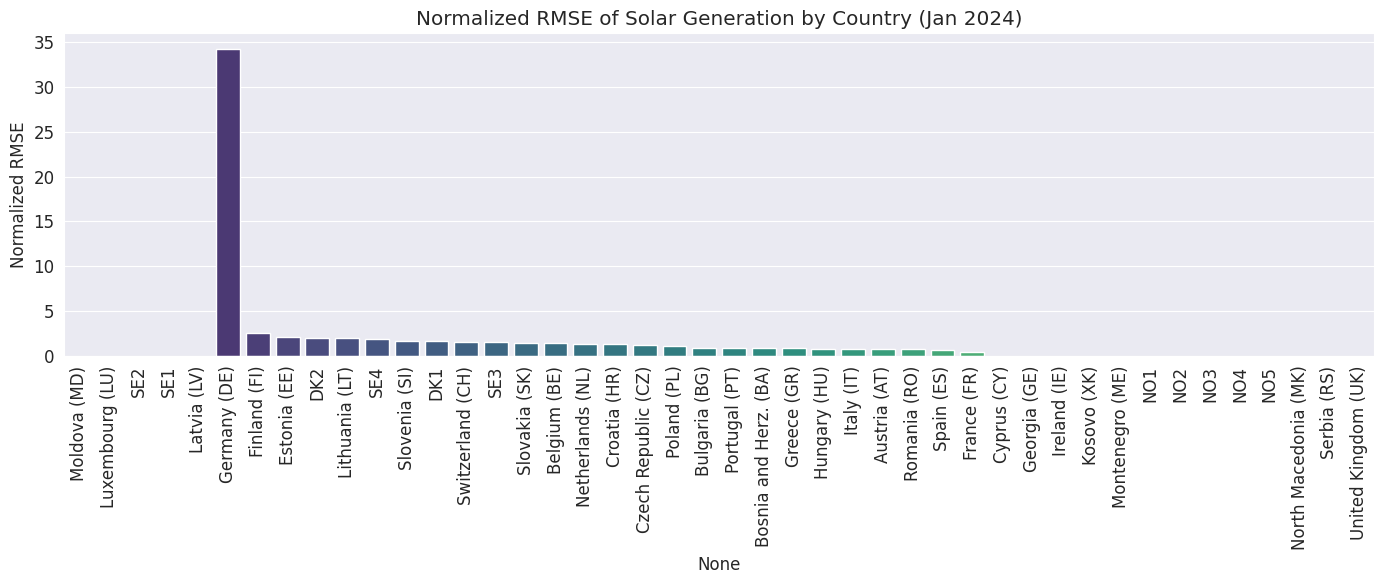

In [38]:
plt.figure(figsize=(14, 6))
rmse_series = metrics_df['RMSE'].astype(float).dropna()
mean_production = ds['pv_power_mw'].mean(dim='time').to_pandas()
normalized_rmse = rmse_series / mean_production
normalized_rmse_series_sorted = normalized_rmse.sort_values(ascending=False)
sns.barplot(x=normalized_rmse_series_sorted.index, y=normalized_rmse_series_sorted.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Normalized RMSE")
plt.title("Normalized RMSE of Solar Generation by Country (Jan 2024)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3937813/2114550995.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rmse_series_sorted.index, y=rmse_series_sorted.values, palette="viridis")


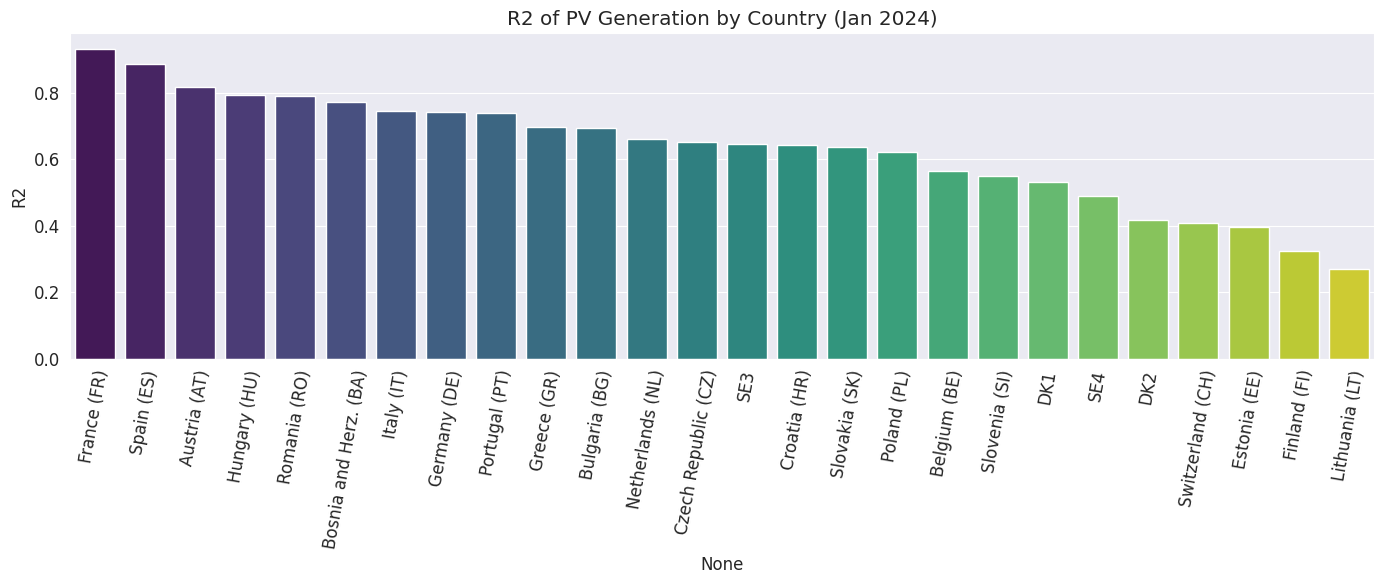

In [39]:
plt.figure(figsize=(14, 6))
rmse_series = metrics_df['R2'].astype(float).dropna()
rmse_series_sorted = rmse_series.sort_values(ascending=False)
sns.barplot(x=rmse_series_sorted.index, y=rmse_series_sorted.values, palette="viridis")
plt.xticks(rotation=80)
plt.ylabel("R2")
plt.title("R2 of PV Generation by Country (Jan 2024)")
plt.tight_layout()
plt.show()

### 4.4 Hydropower Consistency Checks
Present completeness and descriptive statistics of the harmonized hydropower data.

In [ ]:
# Load hydro data
# Check for missing values
# Plot seasonal hydro profiles (Reservoir vs Run-of-river)

### 4.5 Cross-technology and Spatial Correlation
Correlation matrices between wind and solar, and between neighboring countries.

In [ ]:
# Compute correlation matrix of generation time series across countries
# sns.heatmap(corr_matrix)

## 5. Weather-driven Variability Results (2005-2025)
Using the fixed 2025 layout to isolate weather effects.

In [ ]:
# Load long-term 2005-2025 dataset (fixed layout)
# Calculate annual capacity factors
# Plot interannual variability
# plt.bar(years, annual_energy)

## 6. Conclusion